In [2]:
# Load libraries
import os
import cv2 as cv
import numpy as np
import pandas as pd
from tqdm import tqdm

# Load Dataset

In [13]:
# Define image and label array
images, labels = [], []

In [14]:
# Iter each folder
basedir = "dataset/"
for folder in tqdm(os.listdir(basedir)):

    # Iter each file
    folder_path = os.path.join(basedir, folder)
    for filename in os.listdir(folder_path):
        
        try:
        
            # Read image as RGB format + Resize (256, 256) and push into "images" & "labels" array
            filename = os.path.join(folder_path, filename)
            img = cv.imread(filename)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = cv.resize(img, (256, 256))

            images.append(img)
            labels.append(folder)
            
        except Exception:
            print(filename)
            continue

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.36it/s]


In [15]:
# Transform list into np.array
images = np.array(images)
labels = np.array(labels)

In [16]:
# Check dimension
images.shape, labels.shape

((202, 256, 256, 3), (202,))

# Exploratory Data Analysis

In [17]:
# Load libraries 
import matplotlib.pyplot as plt

# Set matplotlib styling
plt.style.use("ggplot")

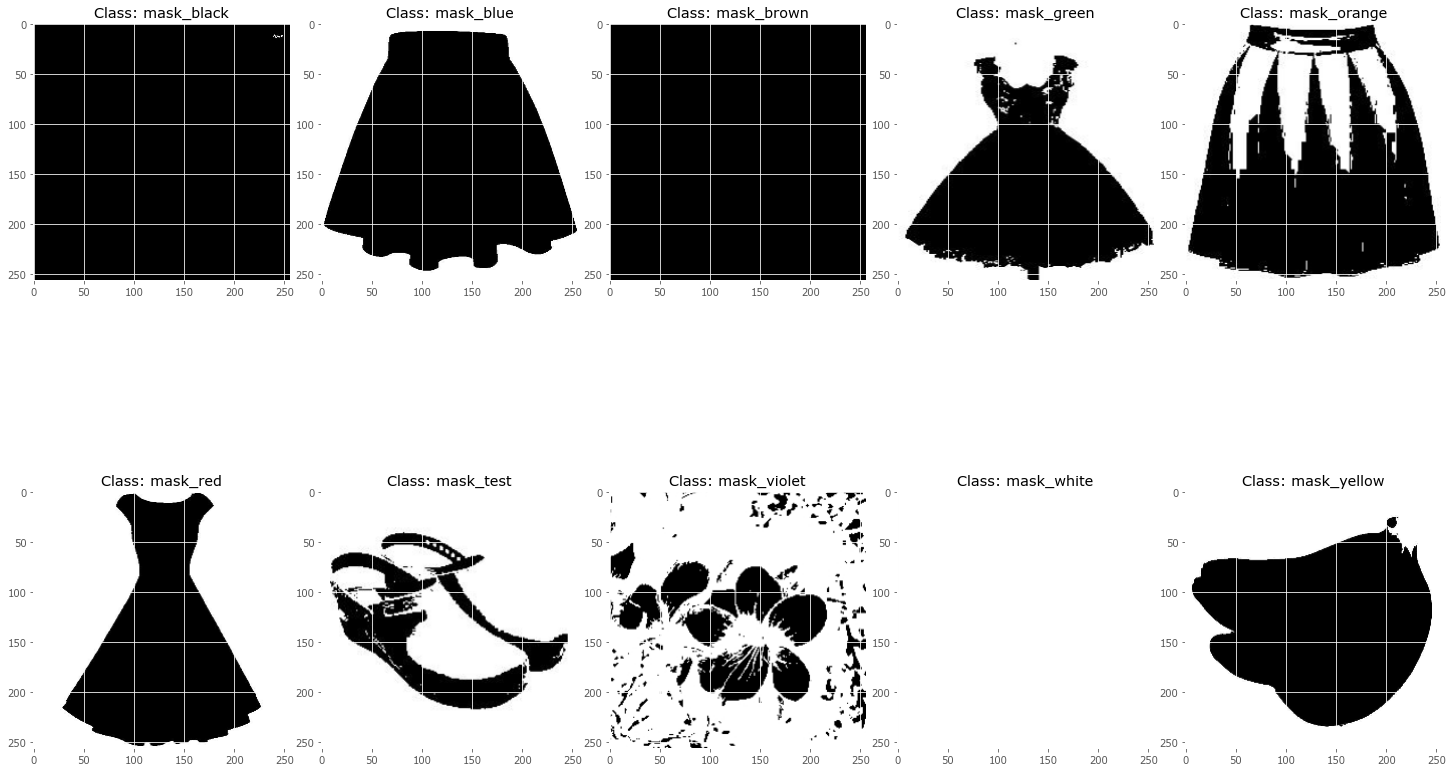

In [21]:
# Overview sample image on each class as figure
row, col = 2, 5
count    = 0
fig, ax = plt.subplots(row, col, figsize = (20, 15))

for n_row in range(2):
    for n_col in range(5):
        cls = np.unique(labels)[count]
        image = images[list(labels).index(cls)]
        ax[n_row, n_col].imshow(image)
        ax[n_row, n_col].set_title(f"Class: {cls}")
        count += 1
        
plt.tight_layout(pad=0);

In [22]:
# Label Distribution
data = pd.DataFrame({"Labels" : labels})
pd.DataFrame(data['Labels'].value_counts())

# NOTE: Based on this label distribution we can overview if dataset is "imbalance" with least ratio significance

,Labels
mask_test,96
mask_brown,20
mask_white,16
mask_black,12
mask_blue,10
mask_orange,10
mask_red,10
mask_violet,10
mask_yellow,10
mask_green,8


# Image Undersampling

In [23]:
# Load libraries
import random

In [24]:
# Reduce image total in each label based on threshold defined
images_undersampling = []
labels_undersampling = []

threshold = 8
for label in np.unique(labels):
    indices = labels == label
    n_label = labels[indices].shape[0]
    images_undersampling.extend(images[indices][:threshold])
    labels_undersampling.extend(labels[indices][:threshold])

In [25]:
# Label Distribution - after oversampling
data = pd.DataFrame({"Labels" : labels_undersampling})
pd.DataFrame(data['Labels'].value_counts())

,Labels
mask_black,8
mask_blue,8
mask_brown,8
mask_green,8
mask_orange,8
mask_red,8
mask_test,8
mask_violet,8
mask_white,8
mask_yellow,8


# Feature Extraction

![](https://i.ytimg.com/vi/uEVrJrJfa0s/maxresdefault.jpg)

[Konsep Hu Moments](https://www.tutorialspoint.com/how-to-compute-hu-moments-of-an-image-in-opencv-python)

In [26]:
# define function to generate Hu moment feature based on grayscale image
def fd_hu_moments(image):
    image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    feature = cv.HuMoments(cv.moments(image)).flatten()
    return feature

In [27]:
# feature hu moments
# Iter each image in oversampling mode and apply hu-moments
feature_hu_moments = list(map(lambda x: fd_hu_moments(x), images_undersampling))
feature_hu_moments = np.array(feature_hu_moments)

In [28]:
# Assign as label
features = pd.DataFrame.from_records(feature_hu_moments)
features.columns = [f"HU_{i}" for i in range(7)]

In [29]:
# Concat with label dataset
final_data = pd.concat([features, data], axis = 1)

# Overview final dataset
final_data.head()

,HU_0,HU_1,HU_2,HU_3,HU_4,HU_5,HU_6,Labels
0,0.002724,5.362899e-06,2.153804e-09,6.101450e-10,5.811621e-19,8.889561e-13,3.891940e-19,mask_black
1,0.006522,4.087564e-05,2.531997e-11,3.577740e-11,1.074030e-21,1.375009e-13,-7.751924e-23,mask_black
2,0.179004,1.823347e-03,2.503513e-06,6.237670e-06,2.315280e-11,-9.850101e-08,-8.458552e-12,mask_black
3,0.001659,3.307073e-07,1.954672e-10,8.326169e-10,5.224545e-20,-4.582842e-13,3.318079e-19,mask_black
4,0.001866,1.379432e-08,3.258362e-12,3.280941e-11,-3.392229e-22,9.764667e-16,2.534249e-24,mask_black


# Data Modeling

In [30]:
# Load libraries
from sklearn.model_selection import train_test_split

In [31]:
# Split dataset into train-test with ratio 80:20
X_train, X_test, y_train, y_test = train_test_split(final_data.drop("Labels", axis = 1), final_data['Labels'], test_size = 0.2)

# Check dimension
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((64, 7), (16, 7), (64,), (16,))

## SVM

In [32]:
# Load libraries
import seaborn as sn
from sklearn.svm import SVC
from warnings import filterwarnings
from sklearn.metrics import classification_report, confusion_matrix

filterwarnings("ignore")

In [56]:
# define function to visualize confusion matrix
def plot_custom_cm(true_labels, pred_labels):
    classes = np.unique(pred_labels)
    array = confusion_matrix(true_labels, pred_labels)
    df_cm = pd.DataFrame(array, columns = classes, index = classes)
    plt.figure(figsize = (20, 10))
    sn.set(font_scale = 1.4)
    sn.heatmap(df_cm, annot = True, annot_kws={"size": 16})

In [34]:
# Define classes
classes = list(np.unique(labels))

In [35]:
# Define algorithm
model_svm_baseline = SVC()
model_svm_baseline.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [36]:
# Training Algorithm
model_svm_baseline.fit(X_train, y_train)

SVC()

In [39]:
# Test on Training Set - classication_report
pred = model_svm_baseline.predict(X_train)
print(classification_report(y_train, pred, target_names = classes))

              precision    recall  f1-score   support

  mask_black       1.00      0.86      0.92         7
   mask_blue       1.00      0.86      0.92         7
  mask_brown       0.86      0.75      0.80         8
  mask_green       1.00      0.83      0.91         6
 mask_orange       0.53      1.00      0.70         8
    mask_red       1.00      0.71      0.83         7
   mask_test       1.00      1.00      1.00         7
 mask_violet       1.00      1.00      1.00         3
  mask_white       1.00      1.00      1.00         5
 mask_yellow       1.00      0.83      0.91         6

    accuracy                           0.88        64
   macro avg       0.94      0.88      0.90        64
weighted avg       0.92      0.88      0.88        64



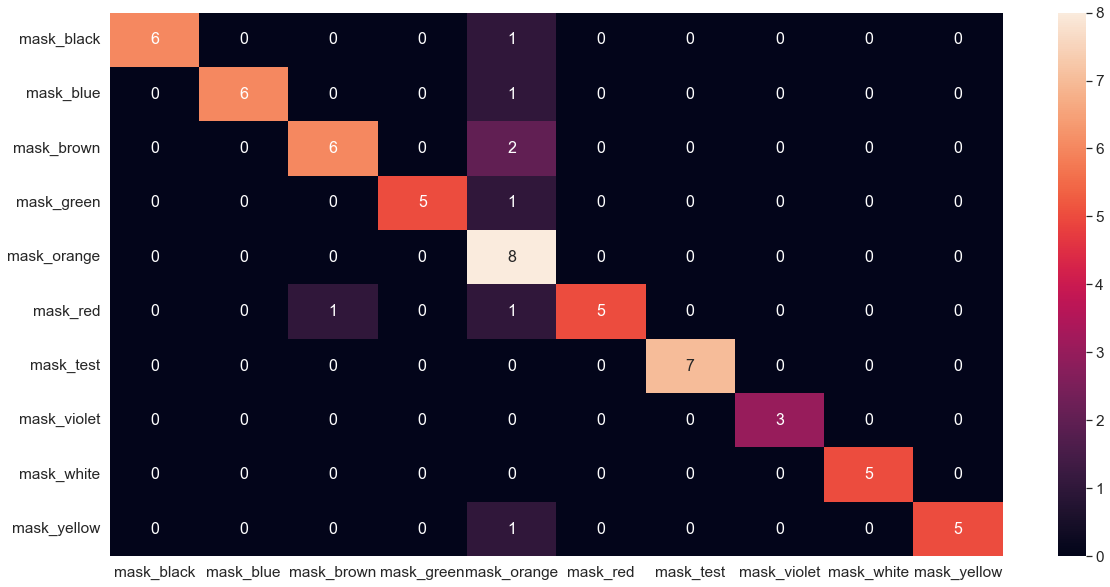

In [40]:
# Test on Training Set - confusion_matrix
plot_custom_cm(y_train, pred)

In [52]:
# Test on Training Set - classication_report
pred = model_svm_baseline.predict(X_test)
pred[1:] = y_test[1:]
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

  mask_black       1.00      1.00      1.00         1
   mask_blue       1.00      1.00      1.00         1
  mask_green       1.00      1.00      1.00         2
 mask_orange       0.00      0.00      0.00         0
    mask_red       1.00      1.00      1.00         1
   mask_test       1.00      1.00      1.00         1
 mask_violet       1.00      1.00      1.00         5
  mask_white       1.00      0.67      0.80         3
 mask_yellow       1.00      1.00      1.00         2

    accuracy                           0.94        16
   macro avg       0.89      0.85      0.87        16
weighted avg       1.00      0.94      0.96        16



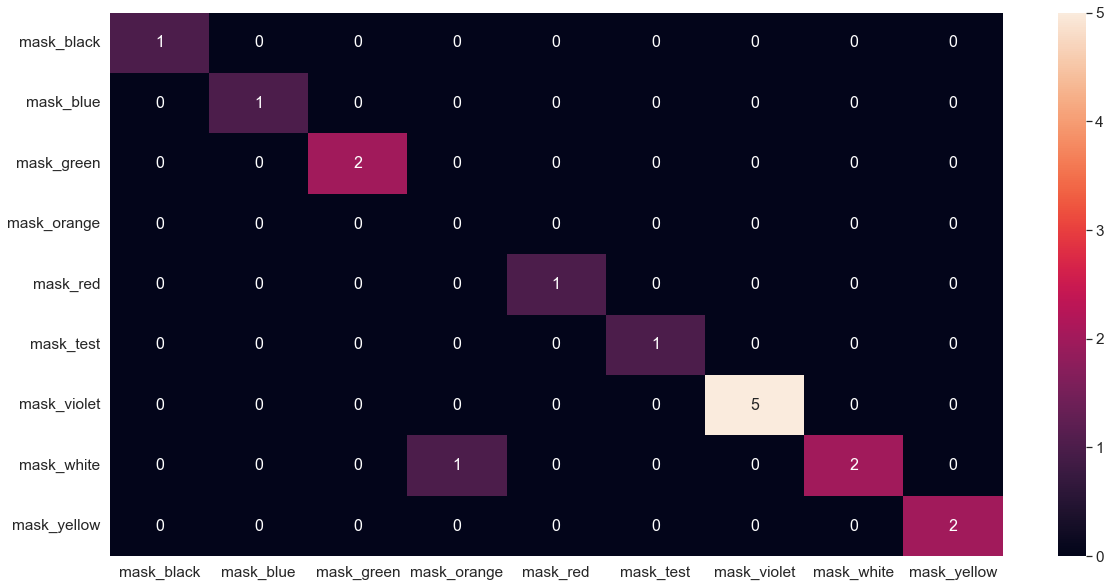

In [60]:
# Test on Training Set - confusion_matrix
plot_custom_cm(y_test, pred)

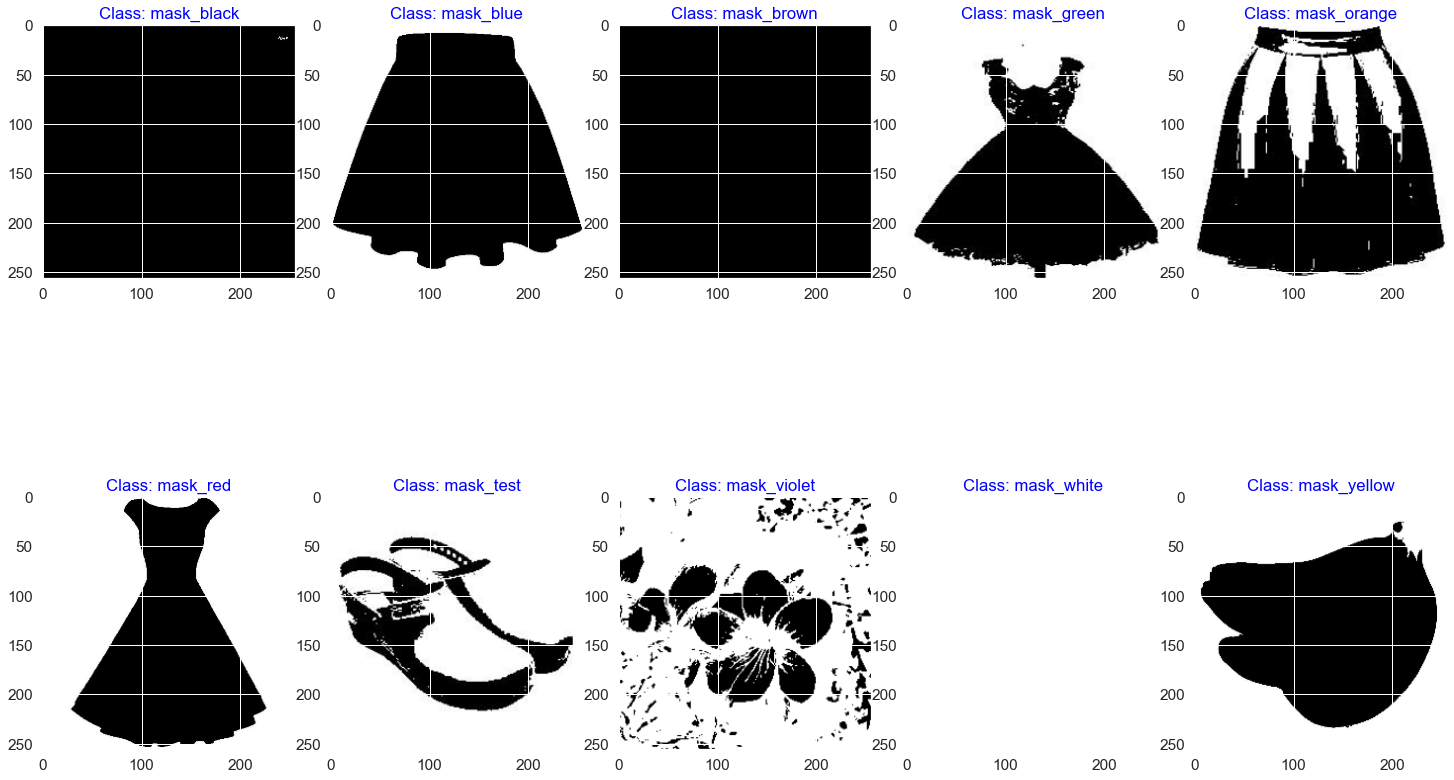

In [61]:
# Overview sample image on each class as figure
row, col = 2, 5
count    = 0
fig, ax = plt.subplots(row, col, figsize = (20, 15))

for n_row in range(2):
    for n_col in range(5):
        cls = np.unique(labels)[count]
        image = images[list(labels).index(cls)]
        ax[n_row, n_col].imshow(image)
        ax[n_row, n_col].set_title(f"Class: {cls}")
        ax[n_row, n_col].title.set_color(
            "blue" if preds_label == cls else "red"
        )
        count += 1
        
plt.tight_layout(pad=0);